In [1]:
import os
os.chdir('../libraries/EAST')

In [2]:
os.getcwd()

'/home/vantuan5644/PycharmProjects/ReceiptOCR/libraries/EAST'

In [4]:
import torch
from torchvision import transforms
from PIL import Image, ImageDraw

# from config import PROJECT_ROOT
from model import EAST
import os
from dataset import get_rotate_mat
import numpy as np
import lanms


In [5]:

def resize_img(img):
	'''resize image to be divisible by 32
	'''
	w, h = img.size
	resize_w = w
	resize_h = h

	resize_h = resize_h if resize_h % 32 == 0 else int(resize_h / 32) * 32
	resize_w = resize_w if resize_w % 32 == 0 else int(resize_w / 32) * 32
	img = img.resize((resize_w, resize_h), Image.BILINEAR)
	ratio_h = resize_h / h
	ratio_w = resize_w / w

	return img, ratio_h, ratio_w


def load_pil(img):
	'''convert PIL Image to torch.Tensor
	'''
	t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
	return t(img).unsqueeze(0)


def is_valid_poly(res, score_shape, scale):
	'''check if the poly in image scope
	Input:
		res        : restored poly in original image
		score_shape: score map shape
		scale      : feature map -> image
	Output:
		True if valid
	'''
	cnt = 0
	for i in range(res.shape[1]):
		if res[0,i] < 0 or res[0,i] >= score_shape[1] * scale or \
           res[1,i] < 0 or res[1,i] >= score_shape[0] * scale:
			cnt += 1
	return True if cnt <= 1 else False


def restore_polys(valid_pos, valid_geo, score_shape, scale=4):
	'''restore polys from feature maps in given positions
	Input:
		valid_pos  : potential text positions <numpy.ndarray, (n,2)>
		valid_geo  : geometry in valid_pos <numpy.ndarray, (5,n)>
		score_shape: shape of score map
		scale      : image / feature map
	Output:
		restored polys <numpy.ndarray, (n,8)>, index
	'''
	polys = []
	index = []
	valid_pos *= scale
	d = valid_geo[:4, :] # 4 x N
	angle = valid_geo[4, :] # N,

	for i in range(valid_pos.shape[0]):
		x = valid_pos[i, 0]
		y = valid_pos[i, 1]
		y_min = y - d[0, i]
		y_max = y + d[1, i]
		x_min = x - d[2, i]
		x_max = x + d[3, i]
		rotate_mat = get_rotate_mat(-angle[i])

		temp_x = np.array([[x_min, x_max, x_max, x_min]]) - x
		temp_y = np.array([[y_min, y_min, y_max, y_max]]) - y
		coordidates = np.concatenate((temp_x, temp_y), axis=0)
		res = np.dot(rotate_mat, coordidates)
		res[0,:] += x
		res[1,:] += y

		if is_valid_poly(res, score_shape, scale):
			index.append(i)
			polys.append([res[0,0], res[1,0], res[0,1], res[1,1], res[0,2], res[1,2],res[0,3], res[1,3]])
	return np.array(polys), index


def get_boxes(score, geo, score_thresh=0.9, nms_thresh=0.2):
	'''get boxes from feature map
	Input:
		score       : score map from model <numpy.ndarray, (1,row,col)>
		geo         : geo map from model <numpy.ndarray, (5,row,col)>
		score_thresh: threshold to segment score map
		nms_thresh  : threshold in nms
	Output:
		boxes       : final polys <numpy.ndarray, (n,9)>
	'''
	score = score[0,:,:]
	xy_text = np.argwhere(score > score_thresh) # n x 2, format is [r, c]
	if xy_text.size == 0:
		return None

	xy_text = xy_text[np.argsort(xy_text[:, 0])]
	valid_pos = xy_text[:, ::-1].copy() # n x 2, [x, y]
	valid_geo = geo[:, xy_text[:, 0], xy_text[:, 1]] # 5 x n
	polys_restored, index = restore_polys(valid_pos, valid_geo, score.shape)
	if polys_restored.size == 0:
		return None

	boxes = np.zeros((polys_restored.shape[0], 9), dtype=np.float32)
	boxes[:, :8] = polys_restored
	boxes[:, 8] = score[xy_text[index, 0], xy_text[index, 1]]
	boxes = lanms.merge_quadrangle_n9(boxes.astype('float32'), nms_thresh)
	return boxes


def adjust_ratio(boxes, ratio_w, ratio_h):
	'''refine boxes
	Input:
		boxes  : detected polys <numpy.ndarray, (n,9)>
		ratio_w: ratio of width
		ratio_h: ratio of height
	Output:
		refined boxes
	'''
	if boxes is None or boxes.size == 0:
		return None
	boxes[:,[0,2,4,6]] /= ratio_w
	boxes[:,[1,3,5,7]] /= ratio_h
	return np.around(boxes)


def detect(img, model, device):
	'''detect text regions of img using model
	Input:
		img   : PIL Image
		model : detection model
		device: gpu if gpu is available
	Output:
		detected polys
	'''
	img, ratio_h, ratio_w = resize_img(img)
	with torch.no_grad():
		score, geo = model(load_pil(img).to(device))
	boxes = get_boxes(score.squeeze(0).cpu().numpy(), geo.squeeze(0).cpu().numpy())
	return adjust_ratio(boxes, ratio_w, ratio_h)


def plot_boxes(img, boxes):
	'''plot boxes on image
	'''
	if boxes is None:
		return img

	draw = ImageDraw.Draw(img)
	for box in boxes:
		draw.polygon([box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]], outline=(0,255,0))
	return img


def detect_dataset(model, device, test_img_path, submit_path):
	'''detection on whole dataset, save .txt results in submit_path
	Input:
		model        : detection model
		device       : gpu if gpu is available
		test_img_path: dataset path
		submit_path  : submit result for evaluation
	'''
	img_files = os.listdir(test_img_path)
	img_files = sorted([os.path.join(test_img_path, img_file) for img_file in img_files])

	for i, img_file in enumerate(img_files):
		print('evaluating {} image'.format(i), end='\r')
		boxes = detect(Image.open(img_file), model, device)
		seq = []
		if boxes is not None:
			seq.extend([','.join([str(int(b)) for b in box[:-1]]) + '\n' for box in boxes])
		with open(os.path.join(submit_path, 'res_' + os.path.basename(img_file).replace('.jpg','.txt')), 'w') as f:
			f.writelines(seq)

In [268]:
img_path = os.path.join('/home/vantuan5644/PycharmProjects/ReceiptOCR/datasets/OCR/product_attributes/img_7_25_12_padded_9.jpg')


In [269]:
model_path = 'pths/east_vgg16.pth'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
img = Image.open(img_path)
boxes = detect(img, model, device)
plot_img = plot_boxes(img, boxes)

In [270]:
polygons = boxes[:,:-1]

In [271]:
polygon = polygons[0].reshape(-1, 2)
polygon

array([[140.,  18.],
       [192.,  19.],
       [192.,  34.],
       [140.,  32.]], dtype=float32)

In [272]:
top_left = polygon[np.argmin(np.sum(polygon, axis=1))]
right_bottom = polygon[np.argmax(np.sum(polygon, axis=1))]

print(top_left, right_bottom)

[140.  18.] [192.  34.]


In [273]:
def get_reduced_polygons(polygons):
    top_left_points = []
    right_bottom_points = []

    for polygon in polygons:
        polygon = polygon.reshape(-1, 2)
        top_left = polygon[np.argmin(np.sum(polygon, axis=1))]
        right_bottom = polygon[np.argmax(np.sum(polygon, axis=1))]
#         reduced_polygons.append(np.array([top_left, right_bottom]))
        top_left_points.append(np.array([top_left]))
        right_bottom_points.append(np.array([right_bottom]))

    return np.vstack(top_left_points), np.vstack(right_bottom_points)

In [274]:
tl, rb = get_reduced_polygons(polygons)

In [275]:
tl

array([[140.,  18.],
       [125.,   2.],
       [188.,  -1.],
       [225.,  32.],
       [274.,  20.],
       [196.,  32.],
       [252.,  35.],
       [237.,   5.],
       [304.,  20.],
       [  1.,   0.],
       [276.,   8.]], dtype=float32)

In [276]:
import matplotlib.pyplot as plt

(array([3., 1., 1., 0., 0., 3., 0., 0., 0., 3.]),
 array([-1. ,  2.6,  6.2,  9.8, 13.4, 17. , 20.6, 24.2, 27.8, 31.4, 35. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

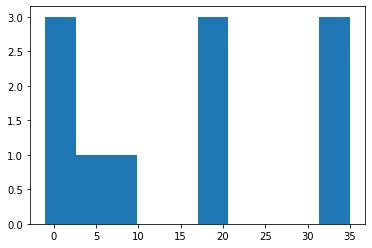

In [277]:
plt.hist(tl[:,1])

In [278]:
counts, values = np.histogram(tl[:,1])
print(counts, values, sep='\n')

[3 1 1 0 0 3 0 0 0 3]
[-1.   2.6  6.2  9.8 13.4 17.  20.6 24.2 27.8 31.4 35. ]


In [279]:
np.nonzero(counts)[0]

array([0, 1, 2, 5, 9])

In [280]:
np.arange(len(counts))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [281]:
def ranges(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return np.array(list(zip(edges, edges)))

In [282]:
ranges(np.nonzero(counts)[0])

array([[0, 2],
       [5, 5],
       [9, 9]])

In [283]:
left_borders = values[ranges(np.nonzero(counts)[0])[:,0]]
left_borders

array([-1. , 17. , 31.4], dtype=float32)

(array([5., 0., 0., 0., 2., 1., 0., 0., 0., 3.]),
 array([19. , 22.7, 26.4, 30.1, 33.8, 37.5, 41.2, 44.9, 48.6, 52.3, 56. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

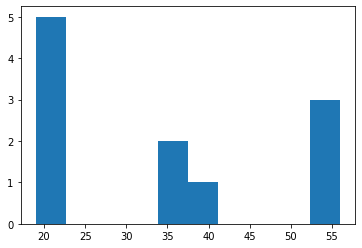

In [284]:
plt.hist(rb[:,1])

In [285]:
counts, values = np.histogram(rb[:,1])
print(counts, values, sep='\n')

[5 0 0 0 2 1 0 0 0 3]
[19.  22.7 26.4 30.1 33.8 37.5 41.2 44.9 48.6 52.3 56. ]


In [286]:
np.nonzero(counts)[0]

array([0, 4, 5, 9])

In [287]:
np.arange(len(counts))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [288]:
ranges(np.nonzero(counts)[0])

array([[0, 0],
       [4, 5],
       [9, 9]])

In [289]:
right_borders = values[ranges(np.nonzero(counts)[0])[:,1]]
right_borders

array([19. , 37.5, 52.3], dtype=float32)

In [290]:
left_borders = np.floor(left_borders).astype(int)
left_borders = np.array(list(map(lambda x: max(0, x), left_borders)))
left_borders

array([ 0, 17, 31])

In [291]:
right_borders = np.ceil(right_borders).astype(int)
right_borders = np.array(list(map(lambda x: max(0, x), right_borders)))

right_borders

array([19, 38, 53])

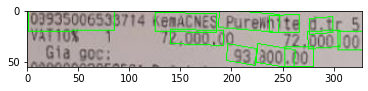

In [292]:
plt.imshow(plot_img)

In [293]:
import cv2

In [294]:
tuple(np.random.choice(range(256), size=3))

(2, 152, 72)

In [295]:
colors = [(255, 0, 0), (0, 255, 0), [0, 0, 255]]

In [296]:
img = plt.imread(img_path)
x_min = 0
x_max = img.shape[1]

rows = []
for i in range(len(left_borders)):
    color = tuple(np.random.randint(256, size=3))
    rows.append(img[left_borders[i]:right_borders[i], x_min:x_max])
#     img = cv2.rectangle(img, (x_min, left_borders[i]), (x_max, right_borders[i]), colors[i])
    


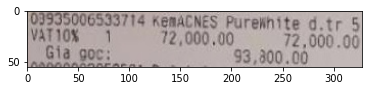

In [297]:
plt.imshow(img)

In [300]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg


In [301]:
config = Cfg.load_config_from_name('vgg_transformer')


In [304]:
config['weights'] = '/home/vantuan5644/PycharmProjects/ReceiptOCR/weights/vietocr/transformerocr.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'

config['cnn']['pretrained'] = True
config['device'] = 'cuda:0'
config['predictor']['beamsearch'] = False


In [305]:
detector = Predictor(config)


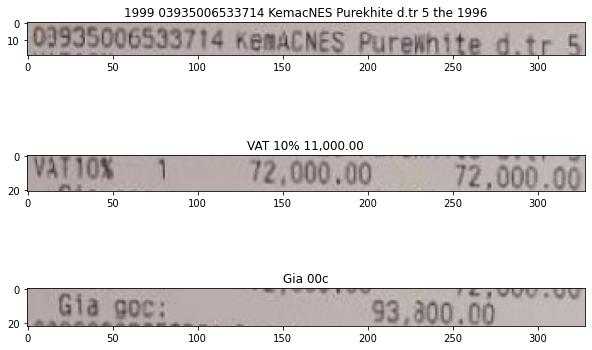

In [314]:
fig, ax = plt.subplots(nrows=len(rows), ncols=1, figsize=(10, 7))

for i, row in enumerate(rows):
    ax[i].imshow(row)
    img = Image.fromarray(row)
    s = detector.predict(img)
    ax[i].title.set_text(s)
plt.show()
